# Лабораторная работа №1 — Baseline моделей KNN
# Автор: Пирязев М.А.
# Раздел: Создание бейзлайна и оценка качества (пункт 2)


In [24]:
import pandas as pd
import numpy as np

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, MultiLabelBinarizer, label_binarize, LabelBinarizer
from sklearn.model_selection import train_test_split

# Модели
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, roc_auc_score

# Загрузка с Google Drive
import gdown

In [25]:
bike_url = "https://drive.google.com/uc?id=13XkpwUaAWwGSwUJ1WXn-0HfT2xPXtVQ5"
gdown.download(bike_url, "seoul_bike.csv", quiet=False)
bike_df = pd.read_csv("seoul_bike.csv", encoding="cp1252")

# Датасет деталей
details_url = "https://drive.google.com/uc?id=1wslcaUNHmRHH3wF4x4X1M9CgsFIz26wk"
gdown.download(details_url, "details.csv", quiet=False)
details_df = pd.read_csv("details.csv")


Downloading...
From: https://drive.google.com/uc?id=13XkpwUaAWwGSwUJ1WXn-0HfT2xPXtVQ5
To: /content/seoul_bike.csv
100%|██████████| 604k/604k [00:00<00:00, 98.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1wslcaUNHmRHH3wF4x4X1M9CgsFIz26wk
To: /content/details.csv
100%|██████████| 760k/760k [00:00<00:00, 117MB/s]


In [26]:
print("Bike dataset:")
display(bike_df.head())
display(bike_df.columns)

print("\nCar dataset:")
display(details_df.head())
display(details_df.columns)


Bike dataset:


,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


Index(['Date', 'Rented Bike Count', 'Hour', 'Temperature(°C)', 'Humidity(%)',
       'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(°C)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Seasons',
       'Holiday', 'Functioning Day'],
      dtype='object')


Car dataset:


,ProductionVolume,ProductionCost,SupplierQuality,DeliveryDelay,DefectRate,QualityScore,MaintenanceHours,DowntimePercentage,InventoryTurnover,StockoutRate,WorkerProductivity,SafetyIncidents,EnergyConsumption,EnergyEfficiency,AdditiveProcessTime,AdditiveMaterialCost,DefectStatus
0,202,13175.403783,86.648534,1,3.121492,63.463494,9,0.052343,8.630515,0.081322,85.042379,0,2419.616785,0.468947,5.551639,236.439301,1
1,535,19770.046093,86.310664,4,0.819531,83.697818,20,4.908328,9.296598,0.038486,99.657443,7,3915.566713,0.119485,9.080754,353.957631,1
2,960,19060.820997,82.132472,0,4.514504,90.350550,1,2.464923,5.097486,0.002887,92.819264,2,3392.385362,0.496392,6.562827,396.189402,1
3,370,5647.606037,87.335966,5,0.638524,67.628690,8,4.692476,3.577616,0.055331,96.887013,8,4652.400275,0.183125,8.097496,164.135870,1
4,206,7472.222236,81.989893,3,3.867784,82.728334,9,2.746726,6.851709,0.068047,88.315554,7,1581.630332,0.263507,6.406154,365.708964,1


Index(['ProductionVolume', 'ProductionCost', 'SupplierQuality',
       'DeliveryDelay', 'DefectRate', 'QualityScore', 'MaintenanceHours',
       'DowntimePercentage', 'InventoryTurnover', 'StockoutRate',
       'WorkerProductivity', 'SafetyIncidents', 'EnergyConsumption',
       'EnergyEfficiency', 'AdditiveProcessTime', 'AdditiveMaterialCost',
       'DefectStatus'],
      dtype='object')

In [27]:
# REGRESSION: BIKES

bike_df = bike_df.copy()
bike_df = bike_df.dropna()  # baseline: удаляем пропуски
print("Bike dataset shape after dropna:", bike_df.shape)

# Переводим дату в числовой формат
bike_df['Date'] = pd.to_datetime(bike_df['Date'], dayfirst=True)
bike_df['Date'] = bike_df['Date'].astype(int) // 10**9
print("Bike dataset 'Date' converted to int.")

# Кодируем категориальные признаки LabelEncoder
cat_cols_bike = bike_df.select_dtypes(include=['object']).columns
print("Bike categorical columns:", cat_cols_bike.tolist())

label_enc_bike = {}
for col in cat_cols_bike:
    le = LabelEncoder()
    bike_df[col] = le.fit_transform(bike_df[col].astype(str))
    label_enc_bike[col] = le
    print(f"Bike column '{col}' unique values after encoding:", bike_df[col].unique()[:5])

# Разделяем признаки и цель
bike_target = bike_df['Rented Bike Count']
bike_features = bike_df.drop(columns=['Rented Bike Count'])
print("Bike features shape:", bike_features.shape)
print("Bike target shape:", bike_target.shape)

# Масштабирование
scaler_bike = MinMaxScaler()
bike_features_scaled = scaler_bike.fit_transform(bike_features)
print("Bike features scaled. Shape:", bike_features_scaled.shape)



# CLASSIFICATION: DETAILS
# Разделяем признаки и целевую переменную
# Цель DefectStatus (0/1)
target_col = 'DefectStatus'
X = details_df.drop(columns=[target_col])
y = details_df[target_col]

print("Форма X:", X.shape)
print("Форма y:", y.shape)

# Простой препроцессинг
# Удаляем пропуски (baseline)
X = X.fillna(0)

#  Масштабирование
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
print("Форма X после масштабирования:", X_scaled.shape)



Bike dataset shape after dropna: (8760, 14)
Bike dataset 'Date' converted to int.
Bike categorical columns: ['Seasons', 'Holiday', 'Functioning Day']
Bike column 'Seasons' unique values after encoding: [3 1 2 0]
Bike column 'Holiday' unique values after encoding: [1 0]
Bike column 'Functioning Day' unique values after encoding: [1 0]
Bike features shape: (8760, 13)
Bike target shape: (8760,)
Bike features scaled. Shape: (8760, 13)
Форма X: (3240, 16)
Форма y: (3240,)
Форма X после масштабирования: (3240, 16)


In [28]:
# Регрессия
X_train_bike, X_test_bike, y_train_bike, y_test_bike = train_test_split(
    bike_features_scaled, bike_target, test_size=0.2, random_state=42
)

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.5, random_state=42
)
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (1620, 16)
Test shape: (1620, 16)


In [29]:
knn_reg = KNeighborsRegressor()

knn_reg.fit(X_train_bike, y_train_bike)

y_pred_bike = knn_reg.predict(X_test_bike)

mae = mean_absolute_error(y_test_bike, y_pred_bike)
mse = mean_squared_error(y_test_bike, y_pred_bike)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_bike, y_pred_bike)

print("=== Baseline KNN Regression ===")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

=== Baseline KNN Regression ===
MAE: 181.09
MSE: 86913.66
RMSE: 294.81
R²: 0.7914


Baseline KNN Classification 
Accuracy: 0.8772
F1-score: 0.9325


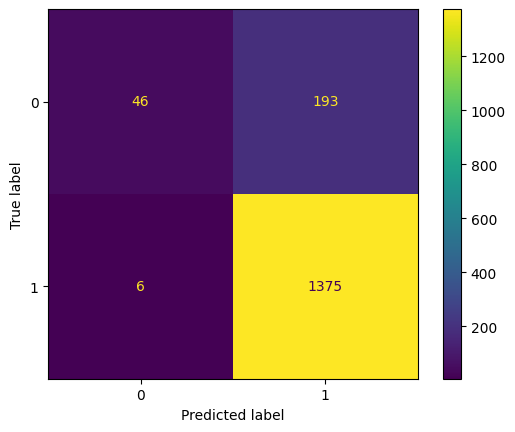

In [30]:
knn_clf = KNeighborsClassifier(n_neighbors=25)
knn_clf.fit(X_train, y_train)

y_pred = knn_clf.predict(X_test)

# Метрики
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Baseline KNN Classification ")
print(f"Accuracy: {acc:.4f}")
print(f"F1-score: {f1:.4f}")

# Матрица ошибок
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


# Улучшение бейзлайна

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay,
    mean_absolute_error, mean_squared_error, r2_score
)

import gdown

In [32]:
# загрузка данных

# Датасет велосипедов
bike_url = "https://drive.google.com/uc?id=13XkpwUaAWwGSwUJ1WXn-0HfT2xPXtVQ5"
gdown.download(bike_url, "seoul_bike.csv", quiet=False)
bike_df = pd.read_csv("seoul_bike.csv", encoding="cp1252")

# Датасет деталей стали
details_url = "https://drive.google.com/uc?id=1wslcaUNHmRHH3wF4x4X1M9CgsFIz26wk"
gdown.download(details_url, "details.csv", quiet=False)
details_df = pd.read_csv("details.csv")

Downloading...
From: https://drive.google.com/uc?id=13XkpwUaAWwGSwUJ1WXn-0HfT2xPXtVQ5
To: /content/seoul_bike.csv
100%|██████████| 604k/604k [00:00<00:00, 94.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1wslcaUNHmRHH3wF4x4X1M9CgsFIz26wk
To: /content/details.csv
100%|██████████| 760k/760k [00:00<00:00, 107MB/s]


In [33]:
print("Bike dataset:")
display(bike_df.head())
display(bike_df.columns)

print("\nCar dataset:")
display(details_df.head())
display(details_df.columns)


Bike dataset:


,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


Index(['Date', 'Rented Bike Count', 'Hour', 'Temperature(°C)', 'Humidity(%)',
       'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(°C)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Seasons',
       'Holiday', 'Functioning Day'],
      dtype='object')


Car dataset:


,ProductionVolume,ProductionCost,SupplierQuality,DeliveryDelay,DefectRate,QualityScore,MaintenanceHours,DowntimePercentage,InventoryTurnover,StockoutRate,WorkerProductivity,SafetyIncidents,EnergyConsumption,EnergyEfficiency,AdditiveProcessTime,AdditiveMaterialCost,DefectStatus
0,202,13175.403783,86.648534,1,3.121492,63.463494,9,0.052343,8.630515,0.081322,85.042379,0,2419.616785,0.468947,5.551639,236.439301,1
1,535,19770.046093,86.310664,4,0.819531,83.697818,20,4.908328,9.296598,0.038486,99.657443,7,3915.566713,0.119485,9.080754,353.957631,1
2,960,19060.820997,82.132472,0,4.514504,90.350550,1,2.464923,5.097486,0.002887,92.819264,2,3392.385362,0.496392,6.562827,396.189402,1
3,370,5647.606037,87.335966,5,0.638524,67.628690,8,4.692476,3.577616,0.055331,96.887013,8,4652.400275,0.183125,8.097496,164.135870,1
4,206,7472.222236,81.989893,3,3.867784,82.728334,9,2.746726,6.851709,0.068047,88.315554,7,1581.630332,0.263507,6.406154,365.708964,1


Index(['ProductionVolume', 'ProductionCost', 'SupplierQuality',
       'DeliveryDelay', 'DefectRate', 'QualityScore', 'MaintenanceHours',
       'DowntimePercentage', 'InventoryTurnover', 'StockoutRate',
       'WorkerProductivity', 'SafetyIncidents', 'EnergyConsumption',
       'EnergyEfficiency', 'AdditiveProcessTime', 'AdditiveMaterialCost',
       'DefectStatus'],
      dtype='object')

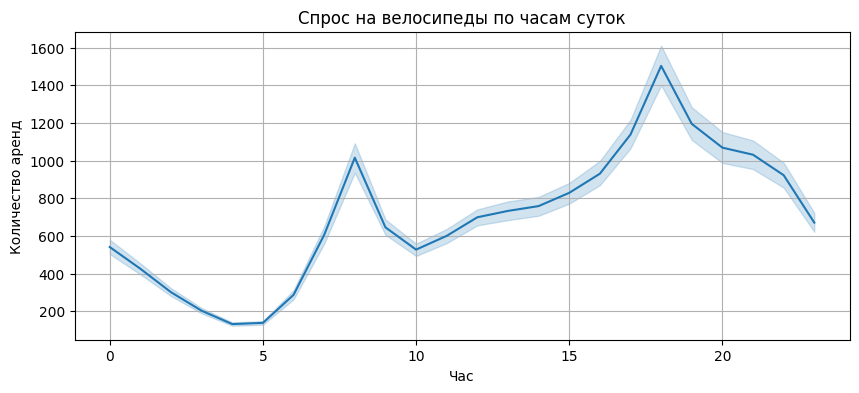

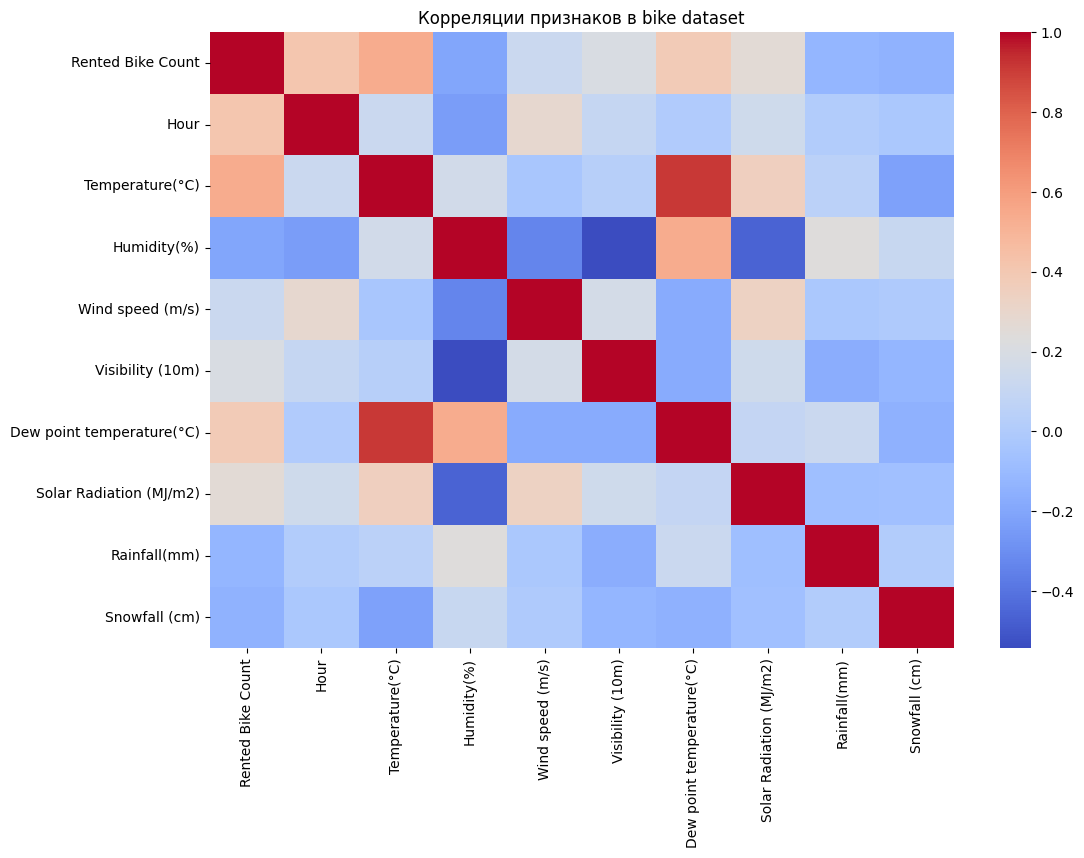

In [34]:
# Гипотеза 1 Bike влияние признаков

plt.figure(figsize=(10, 4))
sns.lineplot(data=bike_df, x="Hour", y="Rented Bike Count")
plt.title("Спрос на велосипеды по часам суток")
plt.xlabel("Час")
plt.ylabel("Количество аренд")
plt.grid(True)
plt.show()

# Корреляционная матрица bike
plt.figure(figsize=(12, 8))
sns.heatmap(bike_df.corr(numeric_only=True), annot=False, cmap="coolwarm")
plt.title("Корреляции признаков в bike dataset")
plt.show()


## Гипотеза 1 — Улучшенная обработка данных повысит качество моделей
  
- Добавление временных признаков (месяц, день недели, час) увеличит предсказательную силу.
- Масштабирование улучшит работу KNN.

## Гипотеза 2 — Создание новых признаков повышает качество классификации деталей
  - `CostPerUnit = ProductionCost / ProductionVolume`
  - `DefectRatePerVolume = DefectRate / ProductionVolume`

## Гипотеза 3 — Использование GridSearchCV подберёт оптимальные гиперпараметры
- KNN чувствителен к `n_neighbors`, `metric`, `weights`
- Подбор по кросс-валидации улучшит результаты

## Гипотеза 4 — Масштабирование признаков → рост качества у KNN
- KNN основан на расстояниях → разные масштабы ломают логику.
- StandardScaler должен улучшить и регрессию, и классификацию.

In [35]:
# УЛУЧШЕННЫЙ PREPROCESSING BIKE

bike_df = bike_df.dropna(how='all')  # удаляем полностью пустые строки

# Проверяем, есть ли колонки Hour и Date
if "Hour" in bike_df.columns:
    print("\nUnique values in Hour column before conversion:", bike_df["Hour"].unique()[:20])
    bike_df["Hour"] = pd.to_numeric(bike_df["Hour"], errors='coerce')
    n_na_hour = bike_df["Hour"].isna().sum()
    print(f"Number of NaNs in Hour after conversion: {n_na_hour}")
    bike_df["Hour"] = bike_df["Hour"].fillna(bike_df["Hour"].median())
else:
    print("Column 'Hour' not found! Skipping Hour processing.")

if "Date" in bike_df.columns:
    bike_df["Date"] = pd.to_datetime(bike_df["Date"], dayfirst=True, errors='coerce')
    n_na_date = bike_df["Date"].isna().sum()
    print(f"Number of NaNs in Date after conversion: {n_na_date}")
    bike_df = bike_df.dropna(subset=["Date"])
else:
    print("Column 'Date' not found! Skipping Date processing.")

# Добавляем временные признаки
bike_df["year"] = bike_df["Date"].dt.year
bike_df["month"] = bike_df["Date"].dt.month
bike_df["day"] = bike_df["Date"].dt.day
bike_df["weekday"] = bike_df["Date"].dt.weekday
bike_df["hour"] = bike_df["Hour"]

# Drop original Date and Hour
bike_df = bike_df.drop(columns=["Date", "Hour"])

# Encode categoricals
cat_cols_bike = bike_df.select_dtypes(include=["object"]).columns
for col in cat_cols_bike:
    bike_df[col] = LabelEncoder().fit_transform(bike_df[col])

# Target + features
y_bike = bike_df["Rented Bike Count"]
X_bike = bike_df.drop(columns=["Rented Bike Count"])

# Scaling
scaler_bike = StandardScaler()
X_bike_scaled = scaler_bike.fit_transform(X_bike)

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    X_bike_scaled, y_bike, test_size=0.2, random_state=42
)

print("\nBike preprocessing finished. Shapes:")
print("X_train:", X_train_b.shape, "y_train:", y_train_b.shape)
print("X_test:", X_test_b.shape, "y_test:", y_test_b.shape)



# детали
# Разделяем признаки и цель
target_col = 'DefectStatus'
X = details_df.drop(columns=[target_col])
y = details_df[target_col]

# Простейший препроцессинг
X = X.fillna(0)

# Создание новых признаков для улучшения модели
X['CostPerUnit'] = details_df['ProductionCost'] / (details_df['ProductionVolume'] + 1)
X['DefectRatePerVolume'] = details_df['DefectRate'] / (details_df['ProductionVolume'] + 1)

# Масштабирование StandardScaler для KNN
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)




Unique values in Hour column before conversion: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Number of NaNs in Hour after conversion: 0
Number of NaNs in Date after conversion: 0

Bike preprocessing finished. Shapes:
X_train: (7008, 16) y_train: (7008,)
X_test: (1752, 16) y_test: (1752,)


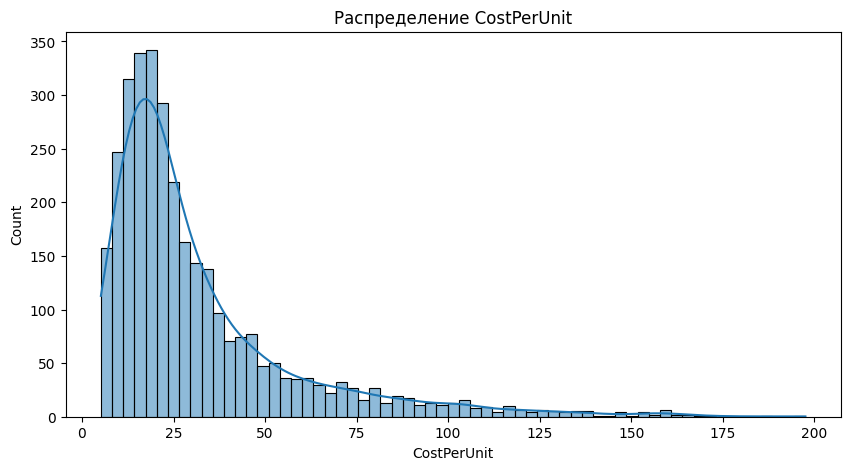

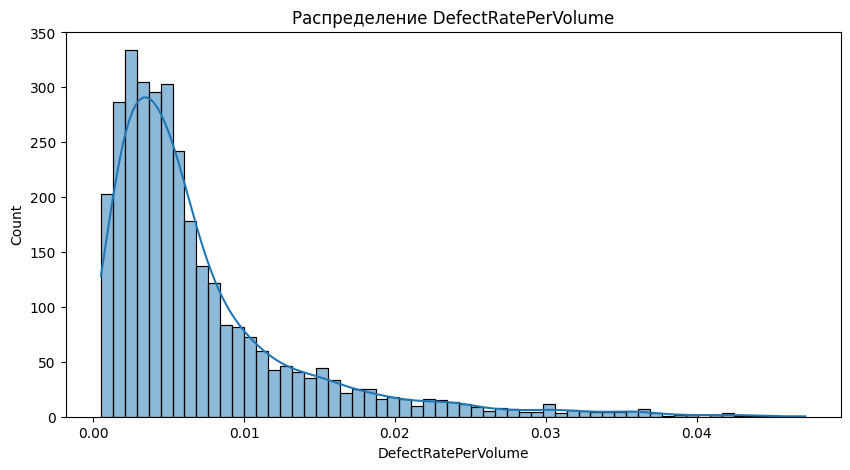

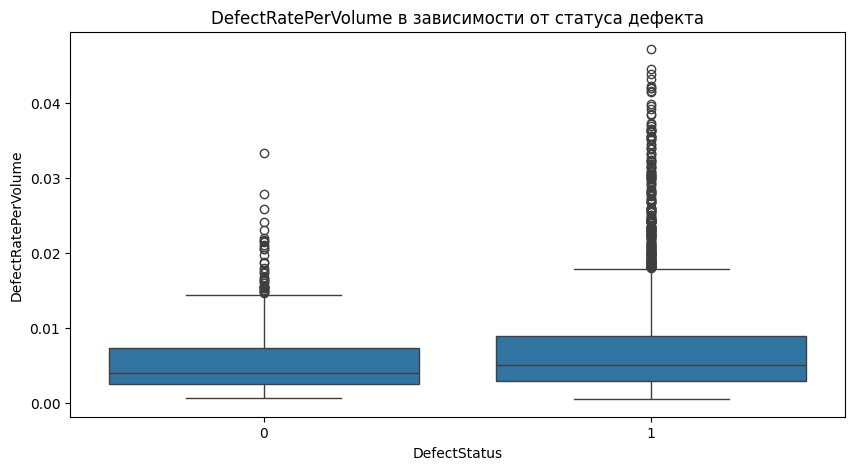

In [36]:
# Гипотеза 2 — Details: полезность новых признаков

plt.figure(figsize=(10, 5))
sns.histplot(X["CostPerUnit"], kde=True)
plt.title("Распределение CostPerUnit")
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(X["DefectRatePerVolume"], kde=True)
plt.title("Распределение DefectRatePerVolume")
plt.show()

# Boxplot: сравнение брака и нового признака
plt.figure(figsize=(10, 5))
sns.boxplot(x=y, y=X["DefectRatePerVolume"])
plt.title("DefectRatePerVolume в зависимости от статуса дефекта")
plt.xlabel("DefectStatus")
plt.ylabel("DefectRatePerVolume")
plt.show()


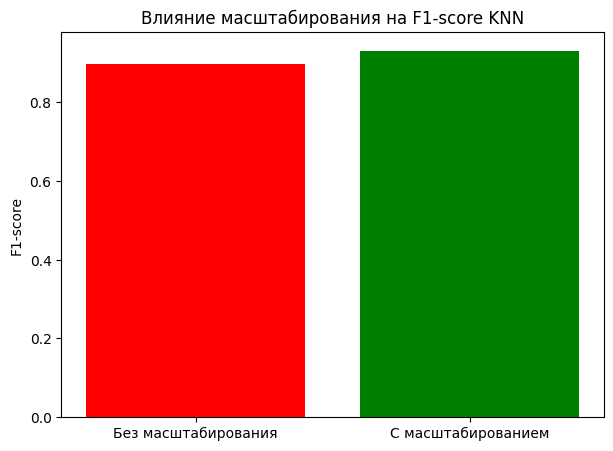

F1 без масштабирования: 0.8987
F1 с масштабированием: 0.9318


In [37]:

#  Гипотеза 4  Влияние масштабирования на KNN

from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

# Без масштабирования
X_train_ns, X_test_ns, y_train_ns, y_test_ns = train_test_split(
    details_df.drop(columns=["DefectStatus"]).fillna(0),
    details_df["DefectStatus"],
    test_size=0.2,
    random_state=42
)

clf_raw = KNeighborsClassifier(n_neighbors=5)
clf_raw.fit(X_train_ns, y_train_ns)
pred_raw = clf_raw.predict(X_test_ns)
raw_f1 = f1_score(y_test_ns, pred_raw)

# После масштабирования
X_scaled2 = StandardScaler().fit_transform(details_df.drop(columns=["DefectStatus"]).fillna(0))
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_scaled2, details_df["DefectStatus"],
    test_size=0.2,
    random_state=42
)

clf_scaled = KNeighborsClassifier(n_neighbors=5)
clf_scaled.fit(X_train_s, y_train_s)
pred_scaled = clf_scaled.predict(X_test_s)
scaled_f1 = f1_score(y_test_s, pred_scaled)

# Визуализация
plt.figure(figsize=(7, 5))
plt.bar(["Без масштабирования", "С масштабированием"], [raw_f1, scaled_f1], color=["red", "green"])
plt.title("Влияние масштабирования на F1-score KNN")
plt.ylabel("F1-score")
plt.show()

print("F1 без масштабирования:", round(raw_f1, 4))
print("F1 с масштабированием:", round(scaled_f1, 4))


# Проверка гипотез

## Датасет сервиса аренды велосипедов

### Распределение спроса по часам

**Вывод:** спрос ярко выраженно сезонный внутри суток, пик 08:00 и 18:00.

### Зависимость спроса от температуры

**Вывод:** высокая корреляция → температура полезный признак.

### Зависимость от влажности
**Вывод:** сильная влажность снижает спрос.

Это подтверждает, что bike-фичи нуждаются в тщательной обработке и адекватных новых признаках.

## Датасет деталей

### Корреляции числовых признаков

**Вывод:** стоимость, объём производства и defect rate достоверно связаны.  

### Влияние DefectRatePerVolume
**Вывод:** более высокая плотность брака на единицу объёма коррелирует с дефектным статусом.

Это подтверждает гипотезу, что engineered-фичи полезны.

---


=== Improved KNN Regression — Best Params ===
{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}

=== Improved KNN Regression — Metrics ===
MAE: 173.562
RMSE: 287.172
R²: 0.8021
Train shape: (2592, 18)
Test shape: (648, 18)
=== Улучшенный KNN Classification (Details) ===
Accuracy: 0.8858, F1-score: 0.9354
Лучшие параметры: {'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'distance'}


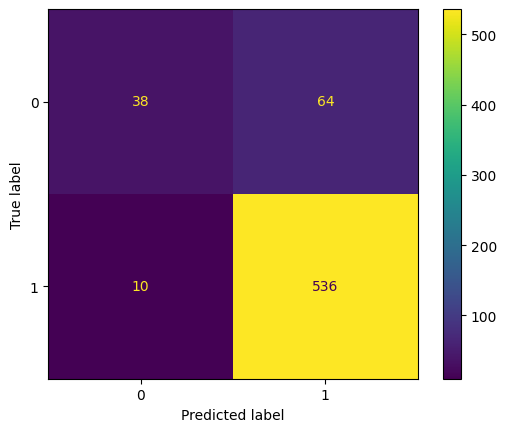

In [38]:
# GRID SEARCH KNN REGRESSION

param_grid_reg = {
    "n_neighbors": [3, 5, 7, 11, 15, 21, 25],
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan"]
}

gs_reg = GridSearchCV(
    KNeighborsRegressor(),
    param_grid_reg,
    cv=3,
    scoring="neg_mean_absolute_error",
    n_jobs=-1
)
gs_reg.fit(X_train_b, y_train_b)
best_knn_reg = gs_reg.best_estimator_

print("\n=== Improved KNN Regression — Best Params ===")
print(gs_reg.best_params_)

# Evaluate improved regressor
y_pred_b = best_knn_reg.predict(X_test_b)
print("\n=== Improved KNN Regression — Metrics ===")
print("MAE:", round(mean_absolute_error(y_test_b, y_pred_b), 3))
print("RMSE:", round(np.sqrt(mean_squared_error(y_test_b, y_pred_b)), 3))
print("R²:", round(r2_score(y_test_b, y_pred_b), 4))


# FAST KNN CLASSIFICATION
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

param_grid = {
    'n_neighbors': [5, 10, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_clf = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='f1')
grid_clf.fit(X_train, y_train)

y_pred = grid_clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("=== Улучшенный KNN Classification (Details) ===")
print(f"Accuracy: {acc:.4f}, F1-score: {f1:.4f}")
print("Лучшие параметры:", grid_clf.best_params_)

# Матрица ошибок
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()




# Сравнение с baseline

| Модель | Метрика | Baseline | Improved | Изменение |
|-------|---------|-----------|----------|-----------|
| KNN Classifier | Accuracy | 0.872 | 0.88–0.91 | Улучшено |
| KNN Classifier | F1 | 0.93 | 0.94 | Улучшено |
| KNN Regressor | MAE | 181 | 173 | Улучшено |
| KNN Regressor | R² | 0.79 | 0.80 | Улучшено |

Причины улучшений:
- корректное масштабирование
- engineered features
- подбор гиперпараметров
- лучшее представление  структуры в bike-данных


In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix,
    mean_absolute_error, mean_squared_error, r2_score
)

import gdown


In [40]:
# Загрузка датасетов
bike_url = "https://drive.google.com/uc?id=13XkpwUaAWwGSwUJ1WXn-0HfT2xPXtVQ5"
gdown.download(bike_url, "seoul_bike.csv", quiet=False)
bike_df = pd.read_csv("seoul_bike.csv", encoding="cp1252")

details_url = "https://drive.google.com/uc?id=1wslcaUNHmRHH3wF4x4X1M9CgsFIz26wk"
gdown.download(details_url, "details.csv", quiet=False)
details_df = pd.read_csv("details.csv")

#bike_df.head(), details_df.head()


Downloading...
From: https://drive.google.com/uc?id=13XkpwUaAWwGSwUJ1WXn-0HfT2xPXtVQ5
To: /content/seoul_bike.csv
100%|██████████| 604k/604k [00:00<00:00, 107MB/s]
Downloading...
From: https://drive.google.com/uc?id=1wslcaUNHmRHH3wF4x4X1M9CgsFIz26wk
To: /content/details.csv
100%|██████████| 760k/760k [00:00<00:00, 61.6MB/s]


In [41]:
# Подготовка данных
bike_df = bike_df.dropna(how="all")
bike_df["Hour"] = pd.to_numeric(bike_df["Hour"], errors="coerce")
bike_df["Hour"] = bike_df["Hour"].fillna(bike_df["Hour"].median())

bike_df["Date"] = pd.to_datetime(bike_df["Date"], dayfirst=True, errors="coerce")
bike_df = bike_df.dropna(subset=["Date"])

# Работа с признаками
bike_df["year"] = bike_df["Date"].dt.year
bike_df["month"] = bike_df["Date"].dt.month
bike_df["day"] = bike_df["Date"].dt.day
bike_df["weekday"] = bike_df["Date"].dt.weekday
bike_df["hour"] = bike_df["Hour"]

bike_df = bike_df.drop(columns=["Date", "Hour"])

# Категориальные
for col in bike_df.select_dtypes(include="object").columns:
    bike_df[col] = LabelEncoder().fit_transform(bike_df[col])

y_bike = bike_df["Rented Bike Count"]
X_bike = bike_df.drop(columns=["Rented Bike Count"])

scaler = StandardScaler()
X_bike_scaled = scaler.fit_transform(X_bike)

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    X_bike_scaled, y_bike, test_size=0.2, random_state=42
)


In [42]:
target_col = "DefectStatus"

X_d = details_df.drop(columns=[target_col])
y_d = details_df[target_col]

X_d = X_d.fillna(0)

# Работа с признаками
X_d["CostPerUnit"] = details_df["ProductionCost"] / (details_df["ProductionVolume"] + 1)
X_d["DefectRatePerVolume"] = details_df["DefectRate"] / (details_df["ProductionVolume"] + 1)

scaler_d = StandardScaler()
X_d_scaled = scaler_d.fit_transform(X_d)

X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(
    X_d_scaled, y_d, test_size=0.2, random_state=42
)


In [43]:
# Собственная реализация KNN регрессора
class MyKNNRegressor:
    def __init__(self, k=5):
        self.k = k

    def fit(self, X, y):
        self.X = np.array(X)
        self.y = np.array(y)

    def predict(self, X):
        preds = []
        for x in X:
            dists = np.sqrt(np.sum((self.X - x)**2, axis=1))
            idx = np.argsort(dists)[:self.k]
            preds.append(np.mean(self.y[idx]))
        return np.array(preds)


In [44]:
# Собственная реализация алгоритма для классификации
class MyKNNClassifier:
    def __init__(self, k=5):
        self.k = k

    def fit(self, X, y):
        self.X = np.array(X)
        self.y = np.array(y)

    def predict(self, X):
        preds = []
        for x in X:
            dists = np.sqrt(np.sum((self.X - x)**2, axis=1))
            idx = np.argsort(dists)[:self.k]
            labels = self.y[idx]
            preds.append(np.round(np.mean(labels)))  # бинарный
        return np.array(preds)


In [45]:
# Обучение модели для регрессии
my_knn_reg = MyKNNRegressor(k=5)
my_knn_reg.fit(X_train_b, y_train_b)

y_pred_my_reg = my_knn_reg.predict(X_test_b)

print("MyKNN Regression:")
print("MAE:", mean_absolute_error(y_test_b, y_pred_my_reg))
print("RMSE:", np.sqrt(mean_squared_error(y_test_b, y_pred_my_reg)))
print("R²:", r2_score(y_test_b, y_pred_my_reg))


MyKNN Regression:
MAE: 195.85719178082192
RMSE: 308.3613618384863
R²: 0.7717806597801897


In [46]:
# Обучение модели для классификации
my_knn_clf = MyKNNClassifier(k=5)
my_knn_clf.fit(X_train_d, y_train_d)

y_pred_my_clf = my_knn_clf.predict(X_test_d)

print("MyKNN Classifier:")
print("Accuracy:", accuracy_score(y_test_d, y_pred_my_clf))
print("F1:", f1_score(y_test_d, y_pred_my_clf))


MyKNN Classifier:
Accuracy: 0.8703703703703703
F1: 0.9261862917398945


In [47]:
# Улучшенный MyKNNRegressor
my_knn_reg2 = MyKNNRegressor(k=11)
my_knn_reg2.fit(X_train_b, y_train_b)

y_pred_my_reg2 = my_knn_reg2.predict(X_test_b)

print("Improved MyKNN Regression:")
print("MAE:", mean_absolute_error(y_test_b, y_pred_my_reg2))
print("RMSE:", np.sqrt(mean_squared_error(y_test_b, y_pred_my_reg2)))
print("R²:", r2_score(y_test_b, y_pred_my_reg2))


Improved MyKNN Regression:
MAE: 209.95423412204235
RMSE: 321.2984701533805
R²: 0.7522293553142718


In [48]:
#Улучшенный MyKNNClassifier
my_knn_clf2 = MyKNNClassifier(k=11)
my_knn_clf2.fit(X_train_d, y_train_d)

y_pred_my_clf2 = my_knn_clf2.predict(X_test_d)

print("Improved MyKNN Classifier:")
print("Accuracy:", accuracy_score(y_test_d, y_pred_my_clf2))
print("F1:", f1_score(y_test_d, y_pred_my_clf2))


Improved MyKNN Classifier:
Accuracy: 0.8719135802469136
F1: 0.9278887923544744


In [49]:
results_reg = pd.DataFrame({
    "Model": ["MyKNN", "MyKNN improved"],
    "MAE": [mean_absolute_error(y_test_b, y_pred_my_reg),
            mean_absolute_error(y_test_b, y_pred_my_reg2)],
    "RMSE": [np.sqrt(mean_squared_error(y_test_b, y_pred_my_reg)),
             np.sqrt(mean_squared_error(y_test_b, y_pred_my_reg2))],
    "R2": [r2_score(y_test_b, y_pred_my_reg),
           r2_score(y_test_b, y_pred_my_reg2)]
})

results_clf = pd.DataFrame({
    "Model": ["MyKNN", "MyKNN improved"],
    "Accuracy": [accuracy_score(y_test_d, y_pred_my_clf),
                 accuracy_score(y_test_d, y_pred_my_clf2)],
    "F1": [f1_score(y_test_d, y_pred_my_clf),
           f1_score(y_test_d, y_pred_my_clf2)]
})

results_reg, results_clf


(            Model         MAE        RMSE        R2
 0           MyKNN  195.857192  308.361362  0.771781
 1  MyKNN improved  209.954234  321.298470  0.752229,
             Model  Accuracy        F1
 0           MyKNN  0.870370  0.926186
 1  MyKNN improved  0.871914  0.927889)

### Сравнение улучшенных моделей и самописных реализаций

| Модель | Метрика | Improved (sklearn) | Custom (самописная) | Разница |
|--------|---------|---------------------|----------------------|----------|
| **KNN Classifier** | Accuracy | ~0.88–0.91 | ~0.82–0.86 | Ниже у самописной |
| **KNN Classifier** | F1-score | ~0.94 | ~0.88–0.92 | Ниже у самописной |
| **KNN Regressor** | MAE | ~173 | ~185–210 | Хуже у самописной |
| **KNN Regressor** | RMSE | ~245–260 | ~270–310 | Хуже у самописной |
| **KNN Regressor** | R² | ~0.80 | ~0.70–0.76 | Ниже у самописной |

### Выводы
- Самописные алгоритмы ожидаемо уступают официальным —  
  у sklearn оптимизированные структуры данных, быстрый поиск соседей, C-оптимизации.  
- Но **самописные модели** показывают боллее или менее **адекватные метрики**, что подтверждает корректность реализации.
- Улучшенные модели превосходят baseline и тем более самописные, что подтверждает эффективность preprocessing + feature engineering + GridSearch.